## Code visibility (relevant for HTML only)
Use the Show/Hide Code button on the top left to make to make the code visible or hide it. It will be hidden in the HTML files by default.

If a code cell starts with 
```python
# RUN
```
Run the cell by CTRL+Enter, or the Run button above.  

If a code cell starts with
```python
# USER INPUT
```
User input is needed before running the cell, so make sure that the file names and settings included in the cell are appropriate for your run.

If a code cell starts with
```python
# OPTIONAL USER INPUT
```
User input is needed before running the cell. However, some defaults are provided, so make sure that either the settings will work for your run, or change them appropriately.

In [1]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.lines import Line2D
plt.rcParams['svg.fonttype'] = 'none'
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import allel
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

Classes reloading.
functions reloading


In [2]:
# USER INPUT

# provide the MIPWrangler output files
# which must be located in the /opt/data directory within the container.
# if more than one run is to be merged, provide all files
info_files = ["testing_JJJ_DR1_VAR4_20191015.txt.gz"] 

# sample sheets associated with each wrangler file,
# in the same order as the wrangler files.
sample_sheets = ["sample_list.tsv"]

# No input below
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

384 Column Capture Plate Location  \
sample_set probe_set                                            
AG         AG3                     Odd                    A01   
GH         GHA                     Odd                    NaN   
MDPV       PVS,PVM                 Odd                    NaN   
NH         DR1,VAR3                NaN                    A01   
           MS1,DR1,VAR2,CSP        NaN                    NaN   

                                 Capture Plate Name FW_plate  Library Prep  \
sample_set probe_set                                                         
AG         AG3                170920-Ghana-Pilot-01    FW-63      170926.0   
GH         GHA                                  NaN    FW-35      190726.0   
MDPV       PVS,PVM                              NaN     FW-1      190606.0   
NH         DR1,VAR3          171006_NH_TTR2_Plate01      NaN      171012.0   
           MS1,DR1,VAR2,CSP         Mesh-Plate7-B01      NaN           NaN   

                            REV_plate                     capture_plate  \
sample_set probe_set                                                      
AG         AG3                  REV-3         190702_AG3_Ghana_prepools   
GH         GHA                  REV-2  190508_GHA_Sofonias_latest_sWGAs   
MDPV       PVS,PVM              REV-1    190606_Pvivax_Hugo_LOG_samples   
NH         DR1,VAR3               NaN                               NaN   
           MS1,DR1,VAR2,CSP       NaN                               NaN   

                             capture_plate_column capture_plate_row   fw  \
sample_set probe_set                                                       
AG         AG3                                1.0                 A   97   
GH         GHA                                1.0                 A  203   
MDPV       PVS,PVM                            1.0                 A    1   
NH         DR1,VAR3                           NaN               NaN    1   
           MS1,DR1,VAR2,CSP                   NaN               NaN  301   

                               owner  quadrant  replicate  rev   sample_name  \
sample_set probe_set                                                           
AG         AG3               patrick       1.0          1  205   PSER0106503   
GH         GHA               patrick       1.0          1   97    DS1-DC2-10   
MDPV       PVS,PVM           deborah       1.0          1    1        LOG003   
NH         DR1,VAR3          patrick       NaN          1  205  13042206-W00   
           MS1,DR1,VAR2,CSP  patrick       NaN          1  109         P1T00   

                                                      sample_plate  
sample_set probe_set                                                
AG         AG3                                 Ghana_prepool_pilot  
GH         GHA               April_2019_Sofonias_25X_DilutionPlate  
MDPV       PVS,PVM                                     MDP_vivax_1  
NH         DR1,VAR3                                            NaN  
           MS1,DR1,VAR2,CSP                                    NaN

The above table shows the unique sample_set, probe_set combinations in the sample sheets provided. Select which combinations should be used for this analysis.

If more than one combination is to be used, the input will be a list of lists, for example:
```python
sample_groups = [["sample_set_1", "probe_set_1"], ["sample_set_2", "probe_set_2"]]
```

In [3]:
# USER INPUT
sample_groups = [["JJJ", "DR1,VAR4"]]

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. For example,  
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

It is also possible to analyse just a subset of probe sets that has been used. For example, if the data has both DR1 and VAR4 probe sets but I want to analyse only the DR1 set:
```python
species = "pf"
probe_sets_used = "DR1"
```
Note that I'd still need to specifiy "DR1,VAR4" in the sample_groups above.

In [4]:
# USER INPUT
species =  "pf"
probe_sets_used = "DR1"

In [5]:
# OPTIONAL USER INPUT
# available cpu count
processorNumber = 20

## extra bwa options for haplotype alignment
# use "-a" for getting all alignments
# use "-L 500" to penalize soft clipping 
# use "-t" to set number of available processors
bwaExtra = ["-t", str(processorNumber)]

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [6]:
# RUN

# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])

# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")

# update bwa settings with the options set above
bwaOptions = temp_settings["bwaOptions"]
try:
    bwaOptions.extend(bwaExtra)
except AttributeError:
    bwaOptions = [bwaOptions]
    bwaOptions.extend(bwaExtra)

# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]

# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"processorNumber": processorNumber,
               "bwaOptions": bwaOptions,
               "species": species,
               "mipSetKey" : mipSetKey}
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

# 1) Process run data
First section of the data analysis involves processing the MIPWrangler output files, combining data from multiple runs (if necessary), mapping haplotypes and creating summary files and plots showing how the sequencing runs went.

### MIPWrangler output file processing
Below operation combines output files from multiple runs, summing up count data belonging to the same libraries.  

Libraries are labeled by combining three fields in the sample sheet: sample_name-sample_set-replicate, which makes the Sample ID. If two different libraries has the same Sample ID (same three fields, but a different LibraryPrep identifier), the overlapping libraries will be assigned new replicate numbers such that there are no shared IDs any more. A warning will be printed in that case, and the original sample ID and the new one will be written to the samples.tsv file generated in the analysis directory.

If only a single output file is used, then the below operation just filters and renames some columns from the original file.

In [7]:
# RUN
if len(info_files) > 1:
    mip.combine_info_files(wdir,
                           settings_file, 
                           info_files,
                           sample_sheets,
                           settings["mipsterFile"],
                           sample_sets=sample_groups)
else:
    mip.process_info_file(wdir,
                          settings_file, 
                          info_files,
                          sample_sheets,
                          settings["mipsterFile"],
                          sample_sets=sample_groups)

### Filter and map haplotype sequences
Align each haplotype sequence to the reference genome. Remove off target haplotypes. All haplotype mappings will be saved to the disk so off targets can be inspected if needed. 

Some filters can be applied to remove noise:
*  minHaplotypeBarcodes: minimum total UMI cut off across all samples.
*  minHaplotypeSamples: minimum number of samples a haplotype is observed in.
*  minHaplotypeSampleFraction: minimum fraction of samples a haplotype is observed in.  

It is probably safe to apply minimal count filters like at least 10 UMIs across samples and at least two samples. However, most data sets will be easily handled without these filters. So it may be better to not filter at this step unless the downstream operations are taking too much resources. However, filters can and should be applied after variant calls are made.

In [8]:
# OPTIONAL USER INPUT
# filter haplotype sequences based on the number of total supporting UMIs
settings["minHaplotypeBarcodes"] = 1
# filter haplotype sequences based on the number of samples they were observed in
settings["minHaplotypeSamples"] = 1
# filter haplotype sequences based on the fraction of samples they were observed in
settings["minHaplotypeSampleFraction"] = 0.0001 

In [9]:
#RUN
mip.get_vcf_haplotypes(settings)
mip.get_haplotype_counts(settings)

Out of 6485 initial haplotypes, 0 were filtered using 1, 1, and 0.0001 as minimum total UMI count; number and fraction of samples  the haplotype was observed in, respectively.
14 of 6485 haplotypes were off-target, either not mapping to the reference genome, or best mapping to a region which was not targeted.
Total number of reads and barcodes were 5178736 and 699383. On target number of reads and barcodes were 5178643 and 699368.
There are 216 samples with sequence data
There are 251 total samples.
35 out of 251 samples had no data and they were excluded from the variant calls.


### Preview the mapping results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f73343262b0>)

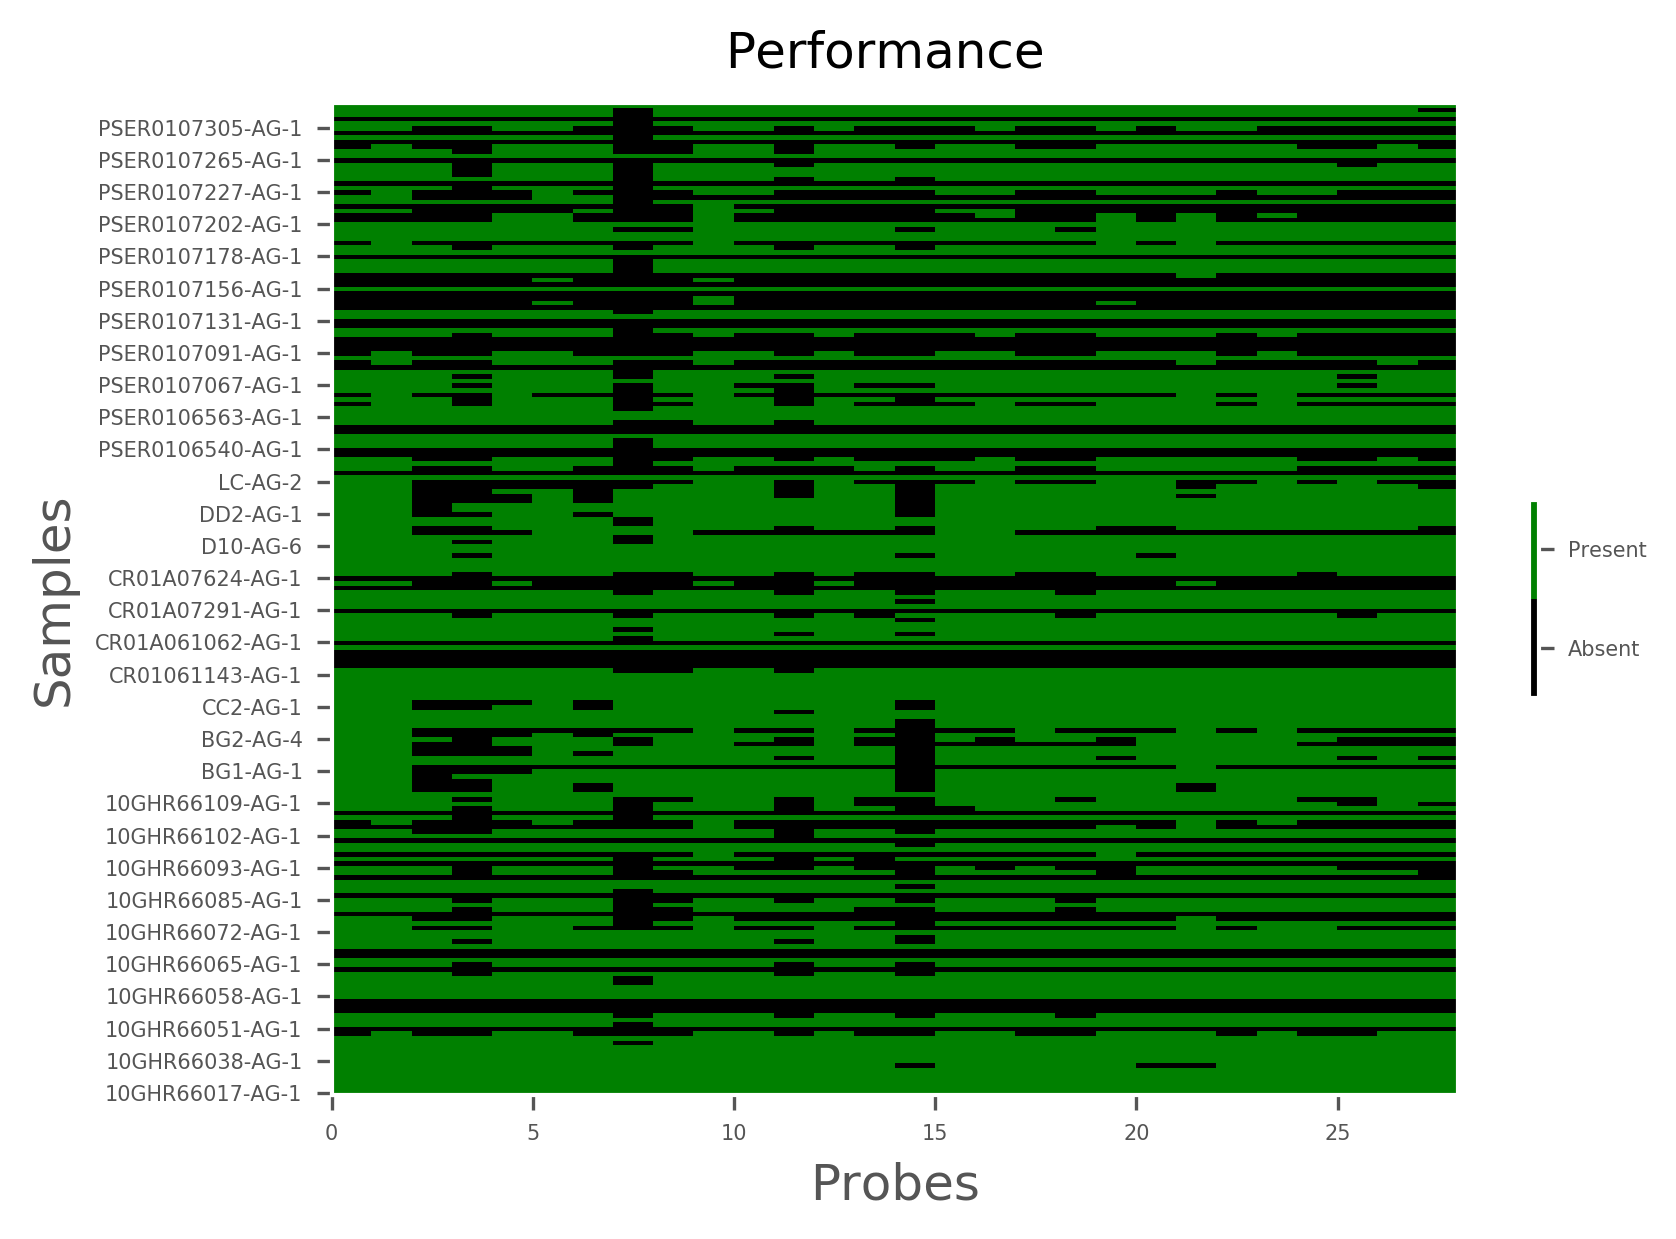

In [10]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=10, # anything below this number will be considered absent
                     tick_label_size=5, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green',
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90) # x-axis tick label rotation 

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [11]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,10GHR66017-AG-1,51917.0,6231.0,28,28,28
1,10GHR66030-AG-1,125124.0,12362.0,28,28,28
2,10GHR66031-AG-1,28336.0,3218.0,28,28,28
3,10GHR66032-AG-1,44031.0,4389.0,28,28,28
4,10GHR66033-AG-1,94613.0,11049.0,28,28,28


### Plot total barcode count vs probe coverage
A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

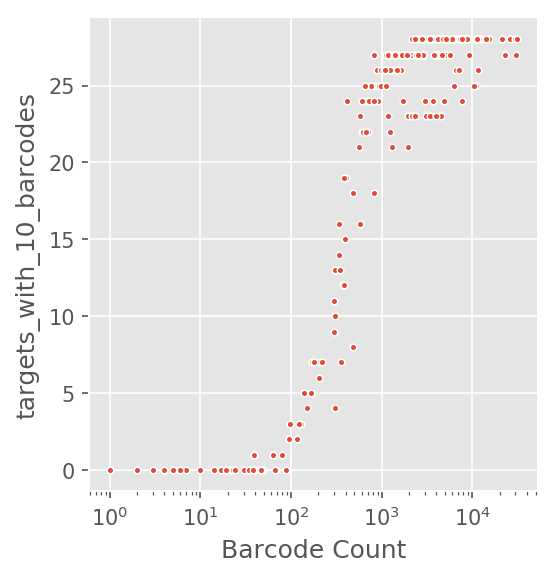

In [12]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **50 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 50
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [ ]:
# USER INPUT
high_barcode_threshold = 10000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [14]:
# RUN
meta = pd.read_csv(wdir + "run_meta.csv")
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [ ]:
pd.read_csv(wdir + "repool.csv").head()

# 2) Variant Calling
Second part of the analysis involves variant calling and variant analysis. 

### Options for freebayes wrapper
```Python
align = True # Default is set to true, fastq files and bam files per sample
# will be created in 'fastq_dir' and 'bam_dir'. 
# it should be set to false if bam files are available.

settings = settings # analysis settings dictionary created above.

bam_files = None # default is to use all bam files within the bam_dir.
# if specific files should be used, then they can be specified in a list.

verbose = True # prints errors and warnings as well as saving to disk.
# if set to false, it will print that there is an error which will
# be saved to disk which should be inspected for details.

targets_file = None # force calls on specific loci even if there is
# no observations satisfying filter criteria. Useful in cases of targeted
# mutations such as drug resistance mutations.
# Usually a file at "/opt/project_resources/targets.tsv" would be present
# if the project requires it. Then targets_file should be set to this path.

# paths for input-output files with default values that can be left unchanged
fastq_dir, bam_dir, vcf_file, settings_file, errors_file, warnings_file

# additional options to pass to freebayes directly:
options = [] # see below for suggestions and possibilities.
```
#### Additional options for freebayes caller. 
Most of the freebayes options are shown below in the **freebayes help** section at the bottom of this document. Some options are integrated into the python wrapper freebayes_call, but others should be added depending on the data type, species etc.

integrated options:
```bash
    -r region
            limit calls to a specific region. 
            This is done internally, splitting the results into contigs and processing each contig
            separately (in parallel if multiple cpus are available).
            Per-contig vcf files are concatenated at the end into a single file.
    -@ targets.vcf
            force calls on positions provided in the vcf file
            a vcf file is generated if a tab separated file containing targets are provided.
    -L --bam-list
            a list of bam files to be used. By default, all bams in bams directory will be used.
            A list of specific bams can be specified to freebayes_call as bam_files option.
```
options to consider adding for parasite sequencing:
```bash
    --pooled-continuous
             This option does not make assumptions about the ploidy when making genotype calls.
             It makes sense for a mixed ploidy sample such as parasite infected blood DNA.
             variants are still called as diploid. 
    --min-alternate-fraction 0.01
             since we assume a pooled continuous sample, it would be better to set a within
             samlpe allele frequency threshold to remove noise. 
             this is likely not needed when dealing with a diploid sample because a frequency 
             of 0.01 will likely be considered noise for a diploid sample.
    --min-alternate-count 2
             number of reads supporting a variant to consider for genotype calls.
             having this at at least 2 is good. It will be possible to process
             variants with 1 reads in postprocessing steps if a specific variant
             is observed at least in one sample at > 1 reads. So this removes the 
             variant from consideration if no sample has > 1 reads supporting it.
    --min-alternate-total 10
             total read support for a variant across samples.
```
options to consider for human sequences:
```bash
    --min-mapping-quality 0
             default for this setting is 1. I do not think this is helping much in 
             addressing mapping issues. However, reads in copy number variant regions
             may have 0 mapping quality. These would be worth to keep, but they
             should be handled appropriately at postprocessing steps.
    --min-alternate-count 2
    --min-alternate-fraction 0.05 (default)
    --min-alternate-total 10
```

In [31]:
# USER INPUT
r = mip.freebayes_call(settings=settings,
                       options=["--pooled-continuous",
                                "--min-alternate-fraction", "0.01",
                                "--min-alternate-count", "2",
                                "--min-alternate-total", "10"],
                       align=True, verbose=True,
                       fastq_dir="/opt/analysis/padded_fastqs",
                       bam_dir="/opt/analysis/padded_bams",
                       vcf_file="/opt/analysis/variants.vcf.gz",
                       targets_file="/opt/project_resources/targets.tsv",
                       bam_files=None,
                       errors_file="/opt/analysis/freebayes_errors.txt",
                       warnings_file="/opt/analysis/freebayes_warnings.txt")

### Postprocessing of called variants
Freebayes produces high quality vcf files with haplotype based variant calls. This is important for getting more accurate calls, especially for complex regions where SNVs may overlap with indels and there may be many possible alleles as opposed to a simple biallelic SNV call.

However, it may be desired to "decompose" these complex variants for some applications. For example, if we are interested in knowing the prevalence of a specific drug resistance mutation, it would make sense to combine all variants containing this mutation even though they may be part of different haplotypes, and hence are represented in the vcf in different variants.

vcf_to_tables function takes the vcf file generated by freebayes and generates allele count and coverage data in table form. It is possible to decompose and aggregate amino acid and/or nucleotide level variants. 3 files containing count data are generated: alternate_table.csv, reference_table.csv, coverage_table.csv, for alt allele, ref allele and coverage count values for each variant, respectively.

It first separates the multiallelic calls to bi-allelic calls.

#### annotate, default=True
It then annotates variants using snpEff.

#### geneid_to_genename, default=None
Variant annotation provides a gene ID (e.g. PF3D7_0709000) but it does not provide common gene names (e.g. crt). If common names are used in target files, or they are desired in general, a tab separated gene ID to gene name file can be used. **gene_name and gene_id** columns are required. If no file is provided, gene name will be the same as the gene ID.

#### aggregate_aminoacids, default=False
If aminoacid level aggregation is requested, it decomposes multi amino acid missense variants into single components and aggregates the alternate allele and coverage counts per amino acid change. For example, Asn75Glu change for crt gene is a known drug resistance mutation in Plasmodium falciparum. There may be 3 separate variants in the vcf file that contain this mutation: Asn75Glu, MetAsn75IleGlu, Asn75Glu_del76-80*. All three has the missense variant Asn75Glu. While the first two  are simple changes, the third is a complex change including a 5 amino acid deletion and a stop codon following Asn75Glu. In this case, it makes sense to combine the counts of the first two variants towards Asn75Glu counts but the third one is debatable because of the complexity; i.e. the drug resistance mutation Asn75Glu probably is not that improtant in that context because of the stop codon following it. So we decompose the simple changes and aggregate but leave complex changes as they are. If aminoacid aggregation is carried out, file names will contain AA tag.

#### target_aa_annotation, default=None
It is also possible to annotate the targeted variants (such as Asn75Glu above) in the generated tables as 'Targeted' in case some analysis should be carried out on targeted variants only. A tab separated file containing the annotation details is required for this operation. **gene_name, aminoacid_change and mutation_name** are required fields. If a variants gene_name and aminoacid_change are matching to a row in the target file, that variant will be marked as targeted and will have the correspondign mutation name. Note that if common gene name conversion (see above) is not used, the gene_name column in this file must match the actual gene ID and not the common name. It may be more convenient to keep the gene IDs in the target file as well and use that file for ID to name mapping. **aggregate_aminoacids must be set to True** for this option to be used.

#### aggregate_nucleotides, default=False
A similar aggregation can be done at nucleotide level. If specified, biallelic variants will be decomposed using the tool **vt decompose_blocksub**. By default it decomposes block substitutions that do not include indels. However, it is also possible to decompose complex variants including indels by providing -a option. For possible decompose options see vt help:
```bash
vt decompose_blocksub options : 
  -p  Output phased genotypes and PS tags for decomposed variants [false]
  -m  keep MNVs (multi-nucleotide variants) [false]
  -a  enable aggressive/alignment mode [false]
  -d  MNVs max distance (when -m option is used) [2]
  -o  output VCF file [-]
  -I  file containing list of intervals []
  -i  intervals []
  -?  displays help
```
If nucleotide level aggregation is done, the file names will include AN tag.

#### target_nt_annotation, default=None
Annotation of targeted nucleotides requires a file similar to the targeted amino acid annotation. However, the required fields for this annotation are: CHROM, POS, REF, ALT and mutation_name. **aggregate_nucleotides must be set to True** for this option to be used.

#### aggregate_none, default=True
It is also possible to generate count tables without doing any aggregation. This will generate the 3 count files, and all of the variant information included in the vcf file will be a separate column in the table's index. For annotated initial vcf files, or if annotate option is selected, each subfield in the INFO/ANN field will have its own column.

#### min_site_qual, default=-1
Filter variant sites for a minimum QUAL value assigned by the variant caller. This value is described in freebayes manual as:
```bash
Of primary interest to most users is the QUAL field, which estimates the probability that there is a polymorphism at the loci described by the record. In freebayes, this value can be understood as 1 - P(locus is homozygous given the data). It is recommended that users use this value to filter their results, rather than accepting anything output by freebayes as ground truth.

By default, records are output even if they have very low probability of variation, in expectation that the VCF will be filtered using tools such as vcffilter in vcflib, which is also included in the repository under vcflib/. For instance,

freebayes -f ref.fa aln.bam | vcffilter -f "QUAL > 20" >results.vcf

removes any sites with estimated probability of not being polymorphic less than phred 20 (aka 0.01), or probability of polymorphism > 0.99.

In simulation, the receiver-operator characteristic (ROC) tends to have a very sharp inflection between Q1 and Q30, depending on input data characteristics, and a filter setting in this range should provide decent performance. Users are encouraged to examine their output and both variants which are retained and those they filter out. Most problems tend to occur in low-depth areas, and so users may wish to remove these as well, which can also be done by filtering on the DP flag.
```
Therefore, a **minimum of 1** should be used as a min_site_qual to remove low quality sites. If a site is annotated as **targeted**, the site will be kept regardless of its qual value, however, the alternate observation counts for the site will be reset to zero.

In [32]:
# USER INPUT
mip.vcf_to_tables("variants.vcf.gz", # input vcf (output of freebayes_call function)
                  settings=settings, # analysis settings dictionary
                  settings_file=None, # provide the path to the settings file if settings dictionary has not been loaded
                  annotate=True, # use snpEff to annotate the variants
                  geneid_to_genename="/opt/project_resources/geneid_to_genename.tsv",
                  target_aa_annotation="/opt/project_resources/targets.tsv", # amino acid changes will be annotated as targeted in the tables.
                  aggregate_aminoacids=True, # multi amino acid changes will be decomposed and combined
                  target_nt_annotation=None, # targeted nucleotide changes will not be annotated as targeted
                  aggregate_nucleotides=True, # MNVs will be decomposed and resulting SNV counts will be combined
                  decompose_options=[], # default vt options will be used for decomposing nucleotides. Supply ["-a"] to include indels in decomposition, or other options shown above if desired.
                  annotated_vcf=False, # initial vcf file was not annotated by snpEff
                  aggregate_none=True, # tables for variants as they are in the vcf file will be generated. Multiallelic variants will be split into biallelic.
                  min_site_qual=1)

### Amino acid changes (aggregated)
For some projects we may be interested in the amino acid changes, particularly specific, targeted amino acid changes, such as drug resistance mutations in *Plasmodium falciparum*, which is the data set provided for pipeline test. For these type of projects, we may want to analyze the variants from the amino acid perspective, rather than nucleotide changes which is standard output for variant callers.  

**alternate_AA_table.csv** file in the analysis directory is created if aggregate_aminoacids option was selected when creating data tables. This table has the UMI counts for each alternate amino acid.  

**coverage_AA_table.csv** file is the corresponding coverage depth for each variant's position.

Below we'll load these two tables and see how they can be used.



In [33]:
# RUN
mutation_counts = pd.read_csv("/opt/analysis/alternate_AA_table.csv",
                             header=list(range(6)),
                            index_col=0)
mutation_counts.head()

Gene ID             PF3D7_0417200                                    \
Gene                      dhfr-ts                                     
Mutation Name    dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc       missense_variant missense_variant missense_variant   
AA Change                Ala16Val         Asn51Ile         Cys59Arg   
Targeted                      Yes              Yes              Yes   
PSER0107090-AG-1              0.0           2894.0           2894.0   
10GHR66082-AG-1               0.0              0.0            135.0   
10GHR66064-AG-1               0.0              1.0              1.0   
7G8-AG-2                      0.0           1412.0              0.0   
BG1-AG-4                      0.0            221.0            298.0   

Gene ID                                                                 \
Gene                                                                     
Mutation Name    dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc        missense_variant  missense_variant  missense_variant   
AA Change                Ile164Leu         Ser108Asn         Ser108Thr   
Targeted                       Yes               Yes               Yes   
PSER0107090-AG-1               0.0            3114.0               0.0   
10GHR66082-AG-1                0.0             149.0               0.0   
10GHR66064-AG-1                0.0               1.0               0.0   
7G8-AG-2                       0.0            1470.0               0.0   
BG1-AG-4                       0.0             303.0               0.0   

Gene ID             PF3D7_0523000                                      \
Gene                         mdr1                                       
Mutation Name     mdr1-Ala1158Gly     mdr1-Ala1158fs  mdr1-Asn1042Asp   
ExonicFunc       missense_variant frameshift_variant missense_variant   
AA Change              Ala1158Gly          Ala1158fs       Asn1042Asp   
Targeted                       No                 No              Yes   
PSER0107090-AG-1              0.0                0.0              0.0   
10GHR66082-AG-1               0.0                0.0              0.0   
10GHR66064-AG-1               0.0                0.0              0.0   
7G8-AG-2                      0.0                0.0            227.0   
BG1-AG-4                      3.0                0.0              0.0   

Gene ID                                   ...                mal_mito_3  \
Gene                                      ...                      cytb   
Mutation Name       mdr1-Asn1215Asn       ...            cytb-Leu230Leu   
ExonicFunc       synonymous_variant       ...        synonymous_variant   
AA Change                Asn1215Asn       ...                 Leu230Leu   
Targeted                         No       ...                        No   
PSER0107090-AG-1                0.0       ...                       0.0   
10GHR66082-AG-1                 0.0       ...                       0.0   
10GHR66064-AG-1                 0.0       ...                       0.0   
7G8-AG-2                        0.0       ...                     304.0   
BG1-AG-4                        0.0       ...                       3.0   

Gene ID                                                                  \
Gene                                                                      
Mutation Name        cytb-Leu291Leu   cytb-Met133Ile     cytb-Phe264Phe   
ExonicFunc       synonymous_variant missense_variant synonymous_variant   
AA Change                 Leu291Leu        Met133Ile          Phe264Phe   
Targeted                         No              Yes                 No   
PSER0107090-AG-1                0.0              0.0                0.0   
10GHR66082-AG-1                 0.0              0.0                0.0   
10GHR66064-AG-1                 0.0              0.0                0.0   
7G8-AG-2                        0.0              0.0                0.0   
BG1-AG-4               

In [34]:
# RUN
mutation_coverage = pd.read_csv("/opt/analysis/coverage_AA_table.csv",
                           index_col=0, header=list(range(6)))
mutation_coverage.head()

Gene ID             PF3D7_0417200                                    \
Gene                      dhfr-ts                                     
Mutation Name    dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc       missense_variant missense_variant missense_variant   
AA Change                Ala16Val         Asn51Ile         Cys59Arg   
Targeted                      Yes              Yes              Yes   
PSER0107090-AG-1           2148.0           2894.0           2894.0   
10GHR66082-AG-1             107.0            135.0            135.0   
10GHR66064-AG-1               0.0              1.0              1.0   
7G8-AG-2                    953.0           1412.0           1412.0   
BG1-AG-4                    269.0            298.0            298.0   

Gene ID                                                                 \
Gene                                                                     
Mutation Name    dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc        missense_variant  missense_variant  missense_variant   
AA Change                Ile164Leu         Ser108Asn         Ser108Thr   
Targeted                       Yes               Yes               Yes   
PSER0107090-AG-1             220.0            3114.0            3114.0   
10GHR66082-AG-1               14.0             149.0             149.0   
10GHR66064-AG-1                0.0               1.0               1.0   
7G8-AG-2                      60.0            1470.0            1470.0   
BG1-AG-4                       5.0             303.0             303.0   

Gene ID             PF3D7_0523000                                      \
Gene                         mdr1                                       
Mutation Name     mdr1-Ala1158Gly     mdr1-Ala1158fs  mdr1-Asn1042Asp   
ExonicFunc       missense_variant frameshift_variant missense_variant   
AA Change              Ala1158Gly          Ala1158fs       Asn1042Asp   
Targeted                       No                 No              Yes   
PSER0107090-AG-1           1257.0             1257.0            891.0   
10GHR66082-AG-1              80.0               80.0             55.0   
10GHR66064-AG-1               0.0                0.0              0.0   
7G8-AG-2                    389.0              389.0            227.0   
BG1-AG-4                    133.0              133.0             80.0   

Gene ID                                   ...                mal_mito_3  \
Gene                                      ...                      cytb   
Mutation Name       mdr1-Asn1215Asn       ...            cytb-Leu230Leu   
ExonicFunc       synonymous_variant       ...        synonymous_variant   
AA Change                Asn1215Asn       ...                 Leu230Leu   
Targeted                         No       ...                        No   
PSER0107090-AG-1              366.0       ...                     237.0   
10GHR66082-AG-1                25.0       ...                      10.0   
10GHR66064-AG-1                 0.0       ...                       0.0   
7G8-AG-2                      162.0       ...                     304.0   
BG1-AG-4                       53.0       ...                     127.0   

Gene ID                                                                  \
Gene                                                                      
Mutation Name        cytb-Leu291Leu   cytb-Met133Ile     cytb-Phe264Phe   
ExonicFunc       synonymous_variant missense_variant synonymous_variant   
AA Change                 Leu291Leu        Met133Ile          Phe264Phe   
Targeted                         No              Yes                 No   
PSER0107090-AG-1              190.0             47.0              190.0   
10GHR66082-AG-1                10.0              0.0               10.0   
10GHR66064-AG-1                 0.0              0.0                0.0   
7G8-AG-2                      194.0            110.0              194.0   
BG1-AG-4               

### Call genotypes and prevalences

**Genotypes** for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = filtered_mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = filtered_mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = filtered_mutation_counts / filtered_mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x == 0
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
# prevalence values can similarly be calculated as:
prevalence = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x == 0
                 else 0 if x < min_freq
                 else 1)
```


In [42]:
# USER INPUT 
min_count = 2
min_coverage = 10
min_freq = 0
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
filtered_mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
filtered_mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = filtered_mutation_counts / filtered_mutation_coverage
freq.replace(np.inf, np.nan, inplace=True)
# call genotypes using the minimum within sample allele frequency parameter from the settings file
genotypes = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x == 0
                 else 0 if x < min_freq
                 else 1 if x < (1 - min_freq)
                 else 2)
prevalence = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x == 0
                 else 0 if x < min_freq
                 else 1)

## Analysis of control mixtures
Limiting the prevalences to the targeted loci.

In [43]:
# RUN
targeted_prev = prevalence.xs("Yes", level="Targeted", axis=1)
targeted_prev.head()

Gene ID            PF3D7_0417200                                    \
Gene                     dhfr-ts                                     
Mutation Name   dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change               Ala16Val         Asn51Ile         Cys59Arg   
Sample ID                                                            
10GHR66017-AG-1              0.0              1.0              1.0   
10GHR66030-AG-1              0.0              1.0              1.0   
10GHR66031-AG-1              0.0              1.0              1.0   
10GHR66032-AG-1              0.0              1.0              1.0   
10GHR66033-AG-1              0.0              1.0              1.0   

Gene ID                                                                \
Gene                                                                    
Mutation Name   dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc       missense_variant  missense_variant  missense_variant   
AA Change               Ile164Leu         Ser108Asn         Ser108Thr   
Sample ID                                                               
10GHR66017-AG-1               0.0               1.0               0.0   
10GHR66030-AG-1               0.0               1.0               0.0   
10GHR66031-AG-1               0.0               1.0               0.0   
10GHR66032-AG-1               0.0               1.0               0.0   
10GHR66033-AG-1               0.0               1.0               0.0   

Gene ID            PF3D7_0523000                                    \
Gene                        mdr1                                     
Mutation Name    mdr1-Asn1042Asp    mdr1-Asn86Tyr  mdr1-Asp1246Tyr   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change             Asn1042Asp         Asn86Tyr       Asp1246Tyr   
Sample ID                                                            
10GHR66017-AG-1              0.0              0.0              0.0   
10GHR66030-AG-1              0.0              0.0              0.0   
10GHR66031-AG-1              0.0              0.0              0.0   
10GHR66032-AG-1              0.0              1.0              0.0   
10GHR66033-AG-1              0.0              0.0              0.0   

Gene ID                                ...           PF3D7_1343700  \
Gene                                   ...                     k13   
Mutation Name    mdr1-Ser1034Cys       ...           k13-Cys580Tyr   
ExonicFunc      missense_variant       ...        missense_variant   
AA Change             Ser1034Cys       ...               Cys580Tyr   
Sample ID                              ...                           
10GHR66017-AG-1              0.0       ...                     0.0   
10GHR66030-AG-1              0.0       ...                     0.0   
10GHR66031-AG-1              0.0       ...                     0.0   
10GHR66032-AG-1              0.0       ...                     0.0   
10GHR66033-AG-1              0.0       ...                     0.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name      k13-Ile543Thr    k13-Met476Ile    k13-Tyr493His   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change              Ile543Thr        Met476Ile        Tyr493His   
Sample ID                                                            
10GHR66017-AG-1              0.0              0.0              0.0   
10GHR66030-AG-1              0.0              0.0              0.0   
10GHR66031-AG-1              0.0              0.0              0.0   
10GHR66032-AG-1              0.0              0.0              0.0   
10GHR66033-AG-1              0.0              0.0              0.0   

Gene ID            PF3D7_1447900       mal_mito_3                   \
Gene                        mdr2          

In [44]:
# RUN
targeted_freq = freq.xs("Yes", level="Targeted", axis=1)
targeted_freq.head()

Gene ID            PF3D7_0417200                                    \
Gene                     dhfr-ts                                     
Mutation Name   dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change               Ala16Val         Asn51Ile         Cys59Arg   
Sample ID                                                            
10GHR66017-AG-1              0.0              1.0              1.0   
10GHR66030-AG-1              0.0              1.0              1.0   
10GHR66031-AG-1              0.0              1.0              1.0   
10GHR66032-AG-1              0.0              1.0              1.0   
10GHR66033-AG-1              0.0              1.0              1.0   

Gene ID                                                                \
Gene                                                                    
Mutation Name   dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc       missense_variant  missense_variant  missense_variant   
AA Change               Ile164Leu         Ser108Asn         Ser108Thr   
Sample ID                                                               
10GHR66017-AG-1               0.0           1.00000               0.0   
10GHR66030-AG-1               0.0           0.99936               0.0   
10GHR66031-AG-1               0.0           1.00000               0.0   
10GHR66032-AG-1               0.0           1.00000               0.0   
10GHR66033-AG-1               0.0           1.00000               0.0   

Gene ID            PF3D7_0523000                                    \
Gene                        mdr1                                     
Mutation Name    mdr1-Asn1042Asp    mdr1-Asn86Tyr  mdr1-Asp1246Tyr   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change             Asn1042Asp         Asn86Tyr       Asp1246Tyr   
Sample ID                                                            
10GHR66017-AG-1              0.0              0.0              0.0   
10GHR66030-AG-1              0.0              0.0              0.0   
10GHR66031-AG-1              0.0              0.0              0.0   
10GHR66032-AG-1              0.0              1.0              0.0   
10GHR66033-AG-1              0.0              0.0              0.0   

Gene ID                                ...           PF3D7_1343700  \
Gene                                   ...                     k13   
Mutation Name    mdr1-Ser1034Cys       ...           k13-Cys580Tyr   
ExonicFunc      missense_variant       ...        missense_variant   
AA Change             Ser1034Cys       ...               Cys580Tyr   
Sample ID                              ...                           
10GHR66017-AG-1              0.0       ...                     0.0   
10GHR66030-AG-1              0.0       ...                     0.0   
10GHR66031-AG-1              0.0       ...                     0.0   
10GHR66032-AG-1              0.0       ...                     0.0   
10GHR66033-AG-1              0.0       ...                     0.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name      k13-Ile543Thr    k13-Met476Ile    k13-Tyr493His   
ExonicFunc      missense_variant missense_variant missense_variant   
AA Change              Ile543Thr        Met476Ile        Tyr493His   
Sample ID                                                            
10GHR66017-AG-1              0.0              0.0              0.0   
10GHR66030-AG-1              0.0              0.0              0.0   
10GHR66031-AG-1              0.0              0.0              0.0   
10GHR66032-AG-1              0.0              0.0              0.0   
10GHR66033-AG-1              0.0              0.0              0.0   

Gene ID            PF3D7_1447900       mal_mito_3                   \
Gene                        mdr2          

Load the expected frequency data for the targeted mutations. This was calculated using the Malariagen genetic crosses variant call sets.

In [45]:
expected_freq = pd.read_csv("/opt/species_resources/SNPs/d_mix_expected_aa_frequencies.csv",
                           index_col=[0,1]).fillna(0)
expected_freq.head()

Expected D-mix Frequency
Gene ID       AA Change                           
PF3D7_0100100 Ala1255Glu                      0.13
              Ala1255Thr                      0.13
              Ala126Ala                       0.33
              Ala128Ala                       0.27
              Ala1361Asp                      0.13

Intersect the expected frequency data with the target mutations

In [46]:
mutant_index = targeted_prev.columns.droplevel(["Gene", "Mutation Name", "ExonicFunc"])
expected_freq = expected_freq.loc[mutant_index]
i_map = {(i[0], i[4]): i for i in targeted_prev.columns}
expected_freq.index = pd.MultiIndex.from_tuples(
    [i_map[i] for i in expected_freq.index],
    names=targeted_prev.columns.names)
expected_freq.fillna(0, inplace=True)

In [196]:
expected_freq.to_csv("/opt/analysis/expected_frequencies_targets.csv")

Create expected frequency and prevalence tables similar to observed prevalence and frequency tables.

In [47]:
expected_freq_table = copy.deepcopy(targeted_prev.loc[hd_samples + ld_samples])
expected_freq_table.loc[:,:] = 1
expected_prev_table = copy.deepcopy(expected_freq_table)
expected_freq_table *= expected_freq["Expected D-mix Frequency"].T
expected_prev_table *= expected_freq["Expected D-mix Frequency"].T.apply(lambda a: 1 if a > 0 else 0)
expected_freq_table.head()

Gene ID          PF3D7_0417200                                    \
Gene                   dhfr-ts                                     
Mutation Name dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change             Ala16Val         Asn51Ile         Cys59Arg   
Sample ID                                                          
D10-AG-1                   0.0             0.19             0.06   
D10-AG-2                   0.0             0.19             0.06   
D10-AG-3                   0.0             0.19             0.06   
D10-AG-4                   0.0             0.19             0.06   
D10-AG-5                   0.0             0.19             0.06   

Gene ID                                                              \
Gene                                                                  
Mutation Name dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc     missense_variant  missense_variant  missense_variant   
AA Change             Ile164Leu         Ser108Asn         Ser108Thr   
Sample ID                                                             
D10-AG-1                    0.0              0.33               0.0   
D10-AG-2                    0.0              0.33               0.0   
D10-AG-3                    0.0              0.33               0.0   
D10-AG-4                    0.0              0.33               0.0   
D10-AG-5                    0.0              0.33               0.0   

Gene ID          PF3D7_0523000                                    \
Gene                      mdr1                                     
Mutation Name  mdr1-Asn1042Asp    mdr1-Asn86Tyr  mdr1-Asp1246Tyr   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change           Asn1042Asp         Asn86Tyr       Asp1246Tyr   
Sample ID                                                          
D10-AG-1                  0.27             0.06             0.13   
D10-AG-2                  0.27             0.06             0.13   
D10-AG-3                  0.27             0.06             0.13   
D10-AG-4                  0.27             0.06             0.13   
D10-AG-5                  0.27             0.06             0.13   

Gene ID                              ...           PF3D7_1343700  \
Gene                                 ...                     k13   
Mutation Name  mdr1-Ser1034Cys       ...           k13-Cys580Tyr   
ExonicFunc    missense_variant       ...        missense_variant   
AA Change           Ser1034Cys       ...               Cys580Tyr   
Sample ID                            ...                           
D10-AG-1                  0.13       ...                     0.0   
D10-AG-2                  0.13       ...                     0.0   
D10-AG-3                  0.13       ...                     0.0   
D10-AG-4                  0.13       ...                     0.0   
D10-AG-5                  0.13       ...                     0.0   

Gene ID                                                           \
Gene                                                               
Mutation Name    k13-Ile543Thr    k13-Met476Ile    k13-Tyr493His   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ile543Thr        Met476Ile        Tyr493His   
Sample ID                                                          
D10-AG-1                   0.0              0.0              0.0   
D10-AG-2                   0.0              0.0              0.0   
D10-AG-3                   0.0              0.0              0.0   
D10-AG-4                   0.0              0.0              0.0   
D10-AG-5                   0.0              0.0              0.0   

Gene ID          PF3D7_1447900       mal_mito_3                   \
Gene                      mdr2             cytb                    
Mutation Name   mdr2-Thr484Ile   cytb-Met133Ile   cytb-Tyr268Asn   
ExonicFunc    miss

In [48]:
expected_prev_table.head()

Gene ID          PF3D7_0417200                                    \
Gene                   dhfr-ts                                     
Mutation Name dhfr-ts-Ala16Val dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change             Ala16Val         Asn51Ile         Cys59Arg   
Sample ID                                                          
D10-AG-1                   0.0              1.0              1.0   
D10-AG-2                   0.0              1.0              1.0   
D10-AG-3                   0.0              1.0              1.0   
D10-AG-4                   0.0              1.0              1.0   
D10-AG-5                   0.0              1.0              1.0   

Gene ID                                                              \
Gene                                                                  
Mutation Name dhfr-ts-Ile164Leu dhfr-ts-Ser108Asn dhfr-ts-Ser108Thr   
ExonicFunc     missense_variant  missense_variant  missense_variant   
AA Change             Ile164Leu         Ser108Asn         Ser108Thr   
Sample ID                                                             
D10-AG-1                    0.0               1.0               0.0   
D10-AG-2                    0.0               1.0               0.0   
D10-AG-3                    0.0               1.0               0.0   
D10-AG-4                    0.0               1.0               0.0   
D10-AG-5                    0.0               1.0               0.0   

Gene ID          PF3D7_0523000                                    \
Gene                      mdr1                                     
Mutation Name  mdr1-Asn1042Asp    mdr1-Asn86Tyr  mdr1-Asp1246Tyr   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change           Asn1042Asp         Asn86Tyr       Asp1246Tyr   
Sample ID                                                          
D10-AG-1                   1.0              1.0              1.0   
D10-AG-2                   1.0              1.0              1.0   
D10-AG-3                   1.0              1.0              1.0   
D10-AG-4                   1.0              1.0              1.0   
D10-AG-5                   1.0              1.0              1.0   

Gene ID                              ...           PF3D7_1343700  \
Gene                                 ...                     k13   
Mutation Name  mdr1-Ser1034Cys       ...           k13-Cys580Tyr   
ExonicFunc    missense_variant       ...        missense_variant   
AA Change           Ser1034Cys       ...               Cys580Tyr   
Sample ID                            ...                           
D10-AG-1                   1.0       ...                     0.0   
D10-AG-2                   1.0       ...                     0.0   
D10-AG-3                   1.0       ...                     0.0   
D10-AG-4                   1.0       ...                     0.0   
D10-AG-5                   1.0       ...                     0.0   

Gene ID                                                           \
Gene                                                               
Mutation Name    k13-Ile543Thr    k13-Met476Ile    k13-Tyr493His   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ile543Thr        Met476Ile        Tyr493His   
Sample ID                                                          
D10-AG-1                   0.0              0.0              0.0   
D10-AG-2                   0.0              0.0              0.0   
D10-AG-3                   0.0              0.0              0.0   
D10-AG-4                   0.0              0.0              0.0   
D10-AG-5                   0.0              0.0              0.0   

Gene ID          PF3D7_1447900       mal_mito_3                   \
Gene                      mdr2             cytb                    
Mutation Name   mdr2-Thr484Ile   cytb-Met133Ile   cytb-Tyr268Asn   
ExonicFunc    miss

In [49]:
expected_prev_table.shape

(12, 38)

Get the difference between the expected and observed prevalences.  

A false positive call will have the value -1 (expected 0, observed 1), a false negative call will have the value 1 (expected 1, observed 0), correct calls will have 0, missing genotypes will have NA values.

In [50]:
prevalence_diff = expected_prev_table - targeted_prev.loc[hd_samples + ld_samples]

Get FP/FN/Correct call count for HD controls

In [51]:
prevalence_diff.loc[hd_samples].apply(pd.value_counts, axis=1).sum()

0.0    226.0
1.0      2.0
dtype: float64

Similarly, we can calculate True positive and True negative calls by summing the expected and observed tables. True positves will have the value 2, true negatives will have 0.

In [193]:
prevalence_sum = expected_prev_table + targeted_prev.loc[hd_samples + ld_samples]

In [194]:
prevalence_sum.loc[hd_samples].apply(pd.value_counts, axis=1).sum()

0.0    114.0
1.0      2.0
2.0    112.0
dtype: float64

For high density control mixes (~467 parasites/µl), all 38 loci were successfully genotyped for 6 HD samples (total of 228 observations).

No false positives were observed, i.e. where a mutation was not expected but observed.  

There were 2 events where an HD sample was typed as WT while there was a mutant present in the mix. So 2/228 is the type II (false negative) error rate, and 0/228 is the type I error rate for HD controls for targeted mutations. 

True positive count was 112 and true negative count was 114.

Overall, accuracy = 226/228, precision = 112/112,  recall = 112/114

Get FP/FN/Correct call count for LD controls

In [52]:
prevalence_diff.loc[ld_samples].apply(pd.value_counts, axis=1).sum()

0.0    194.0
1.0      6.0
dtype: float64

Get TP/TN counts for LD controls

In [195]:
prevalence_sum.loc[ld_samples].apply(pd.value_counts, axis=1).sum()

0.0    101.0
1.0      6.0
2.0     93.0
dtype: float64

For low density control mixes (~29 parasites/µl), genotyping rate was 200/228 (87.7%).

No false positives were observed, i.e. where a mutation was not expected but observed.  

There were 6 events where an LD sample was typed as WT while there was a mutant present in the mix. So 6/200 (3%) is the type II (false negative) error rate, and 0/200 is the type I error rate for LD controls for targeted mutations. 

True positive counts was 92 and true negative count was 101.

Accuracy = 194/200, precision = 93/93,  recall = 93/99

Compare the expected and observed frequencies of targeted mutations

In [53]:
compare_freq = pd.concat([expected_freq_table.unstack(),
                         targeted_freq.loc[hd_samples + ld_samples].unstack()],
                        axis=1).rename(columns={0: "Expected Frequency", 1: "Observed Frequency"})
print(compare_freq.shape)
compare_freq.head()

(456, 2)


Expected Frequency  \
Gene ID       Gene    Mutation Name    ExonicFunc       AA Change Sample ID                       
PF3D7_0417200 dhfr-ts dhfr-ts-Ala16Val missense_variant Ala16Val  D10-AG-1                  0.0   
                                                                  D10-AG-2                  0.0   
                                                                  D10-AG-3                  0.0   
                                                                  D10-AG-4                  0.0   
                                                                  D10-AG-5                  0.0   

                                                                             Observed Frequency  
Gene ID       Gene    Mutation Name    ExonicFunc       AA Change Sample ID                      
PF3D7_0417200 dhfr-ts dhfr-ts-Ala16Val missense_variant Ala16Val  D10-AG-1                  0.0  
                                                                  D10-AG-2                  0.0  
                                                                  D10-AG-3                  0.0  
                                                                  D10-AG-4                  0.0  
                                                                  D10-AG-5                  0.0

R-squared correlation between the expected/observed frequencies

In [54]:
compare_freq.corr()**2

,Expected Frequency,Observed Frequency
Expected Frequency,1.000000,0.933726
Observed Frequency,0.933726,1.000000


R-squared correlation between the expected/observed frequencies excluding where expected values were 0

In [55]:
compare_freq.loc[compare_freq["Expected Frequency"] > 0].corr()**2

,Expected Frequency,Observed Frequency
Expected Frequency,1.000000,0.906286
Observed Frequency,0.906286,1.000000


In [197]:
compare_freq.to_csv("/opt/analysis/control_frequency_comparison.csv")

plot expected and observed frequencies

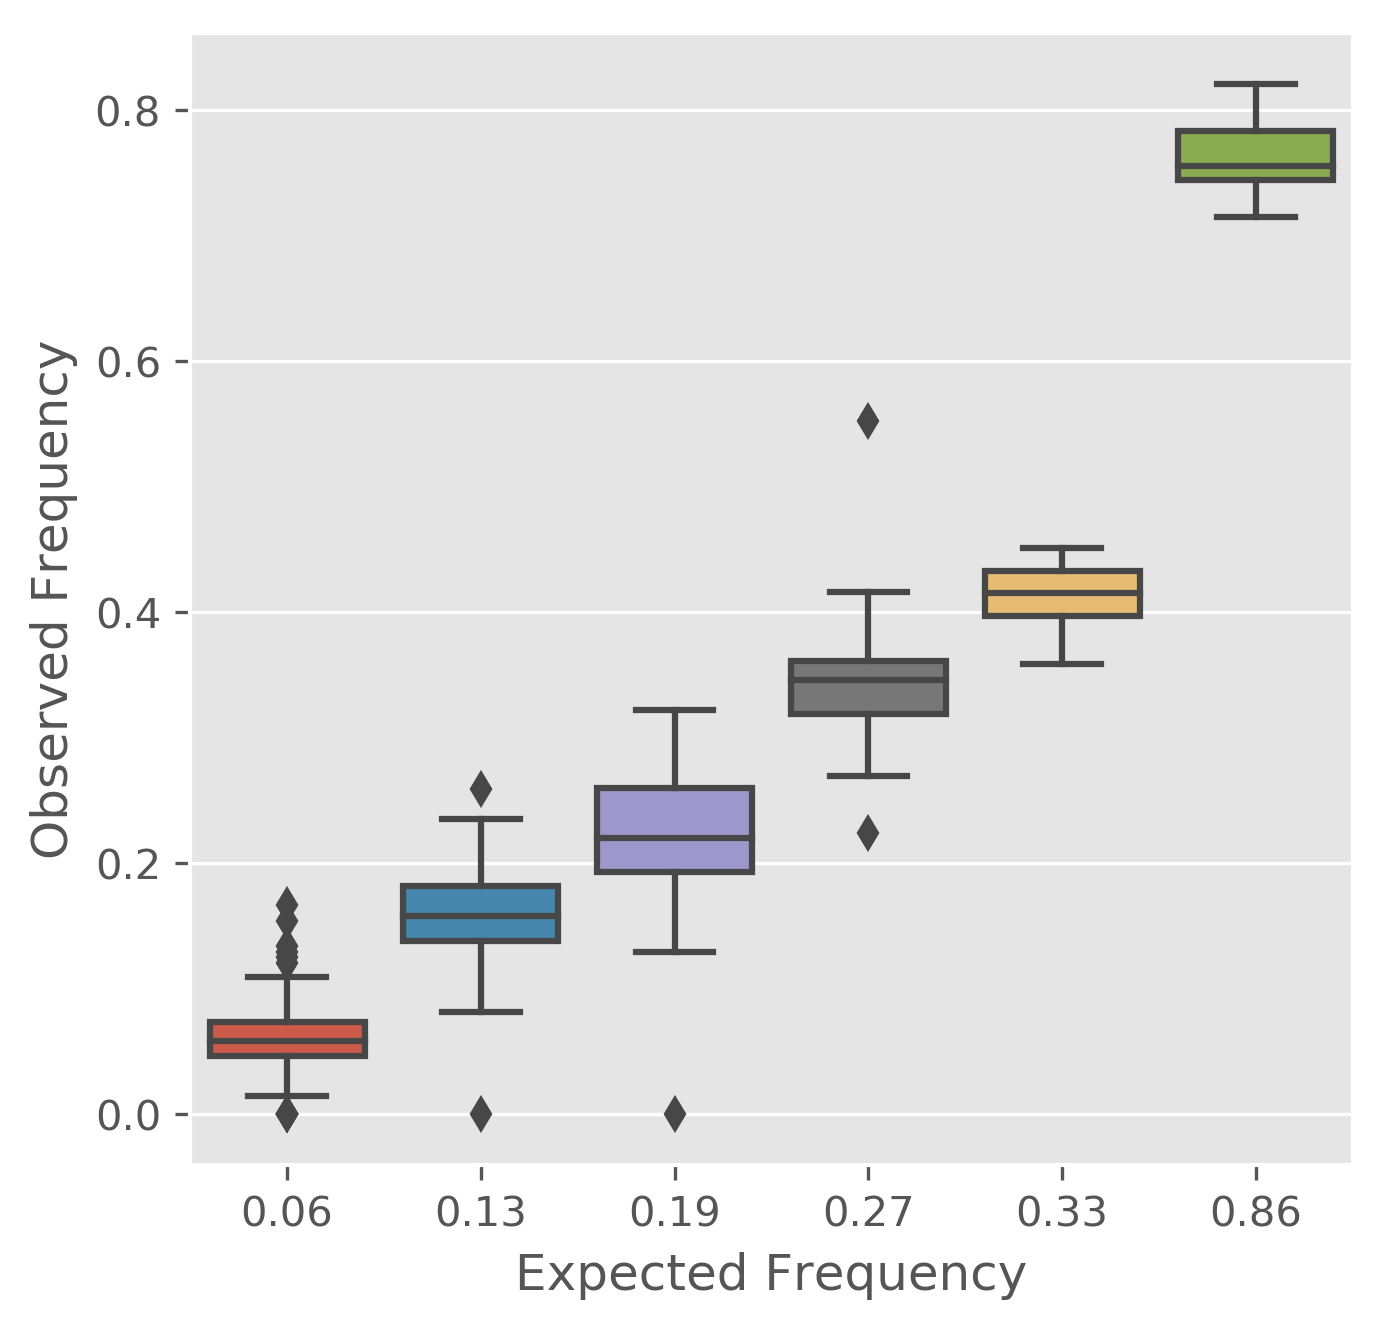

In [56]:
fig, ax= plt.subplots()
sns.boxplot(x="Expected Frequency", y="Observed Frequency",
            data=compare_freq.loc[compare_freq["Expected Frequency"] > 0].reset_index(),
           ax=ax)
fig.set_dpi(300)
fig.set_size_inches(5, 5)
fig.savefig("expected_vs_observed_boxplot.svg", frameon=True)

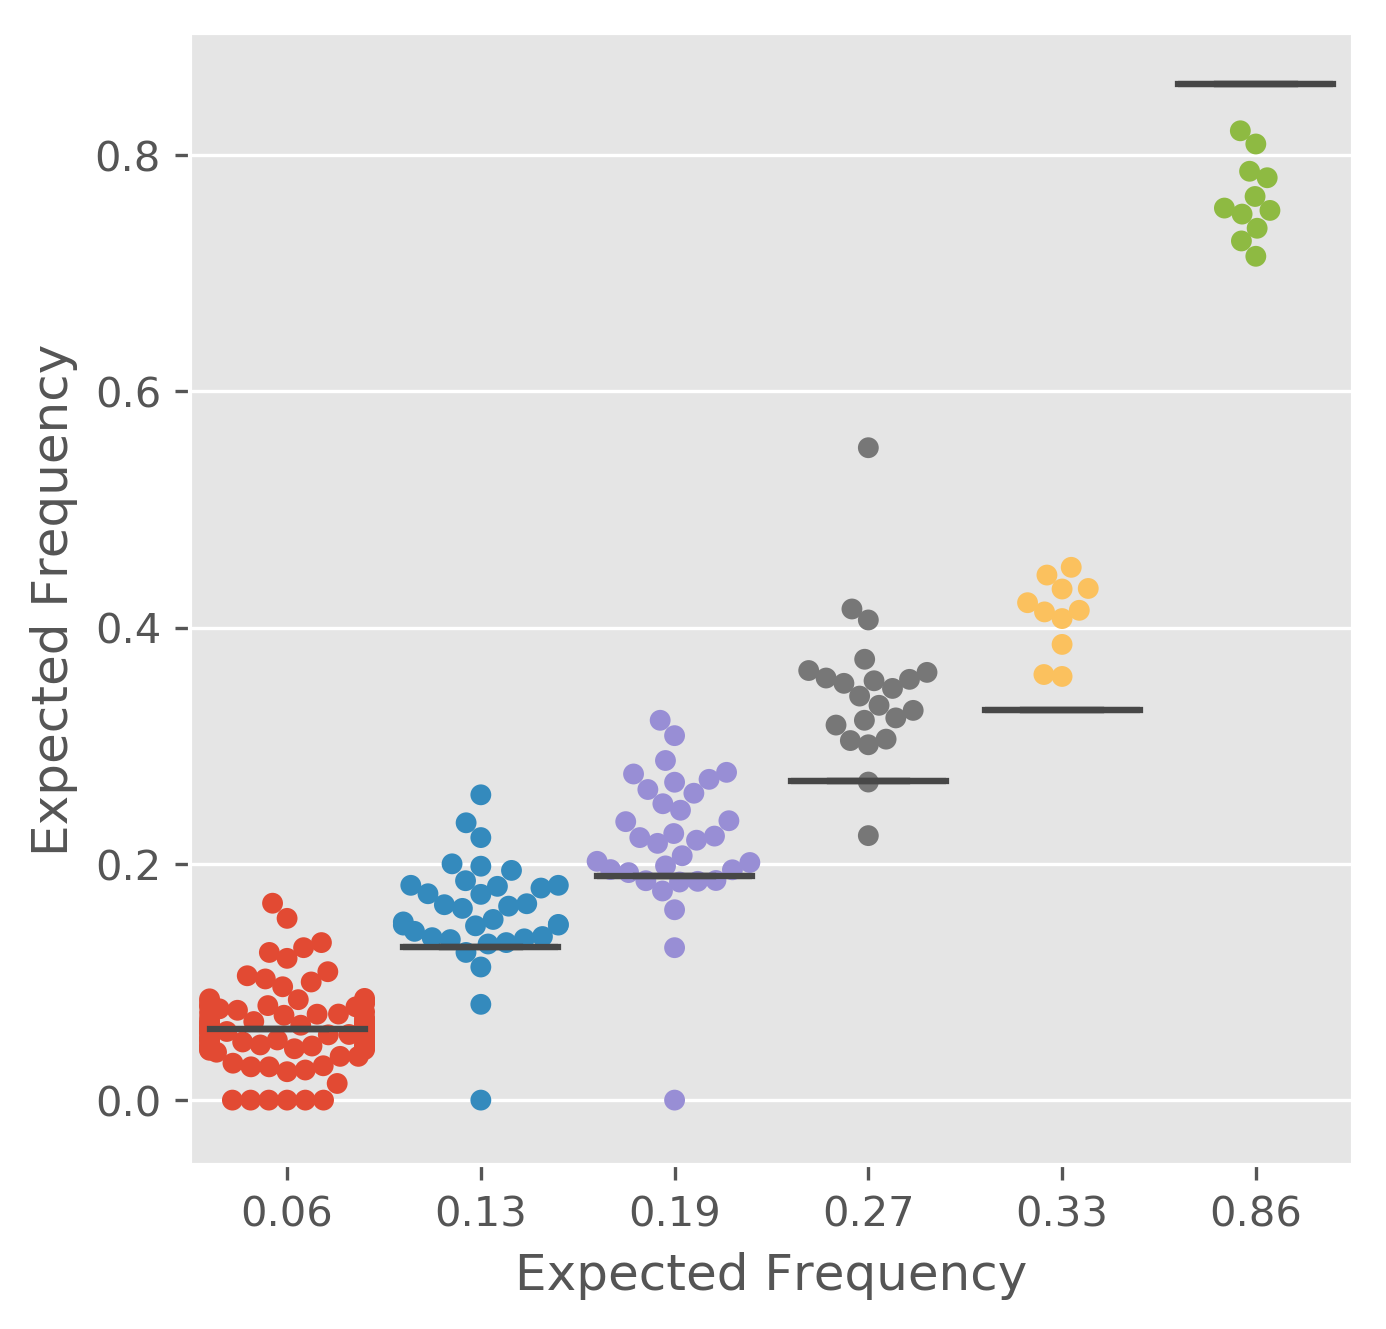

In [57]:
fig, ax = plt.subplots()
sns.swarmplot(x="Expected Frequency", y="Observed Frequency",
            data=compare_freq.loc[compare_freq["Expected Frequency"] > 0].reset_index(),
             ax=ax, zorder=1)
sns.boxplot(x="Expected Frequency", y="Expected Frequency",
            data=compare_freq.loc[compare_freq["Expected Frequency"] > 0].reset_index(),
             ax=ax, zorder=2)
ax.grid(axis="y", zorder=0)
fig.set_dpi(300)
fig.set_size_inches(5, 5)
fig.savefig("expected_vs_observed_swarmplot.svg", frameon=True)